# Tumor-Cut Algorithm
-----
The method is mainly applied to the segmentation of tumors on contrast-enhanced T1-weighted MR images.<br>
The procedure of cellular automata based on tumor segmentation algorithm is shown below. <br><br>
After loading the image(s) for segmentation, 
<br>**_(1) draw a line over the longest visible diameter of the tumor;
<br>(2) using this line, a VOI is selected with foreground-background seeds;
<br>(3) tumor cellular automata (CA) algorithm runs on the VOI for each of the two sets of seeds (foreground and backgroud) to obtain strength maps for foreground and background at each voxel;
<br>(4) two strength maps are combined to obtain the tumor probability maps P<sub>T</sub>;
<br>(5) a level set surface in initialized at P<sub>T</sub> = 0.5 and the map P<sub>T</sub> is used to evolve the surface which converges to the final segmentation map._**
<br>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

### Steps 1 and 2 test

(266, 400, 3)

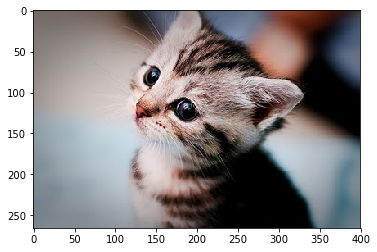

In [2]:
img = cv2.imread('kitten.jpg', 1)
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
RGB_img.shape
#cv2.imshow('Cat', img)
#if cv2.waitKey(0): cv2.destroyAllWindows()
    

The procedure of seed selection, starting with a single line drawn along the longest visible diameter of the tumor, is  demonstrated below.  Afterward, the VOI and the seeds will be computed as follows: <br>
_1) The line drawn will be cropped by 15% of the length from each end and then be thicken to 3 pixels wide to obtain tumor seeds : foreground seeds (red line segment)._<br>
_2) VOI will be selected as the bounding box of the sphere with a diameter 35% larger than the line segment._ <br>
_3) One-voxel-wide border of the VOI will be used as background seeds._


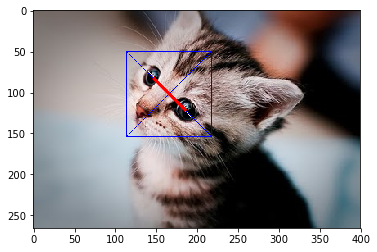

In [3]:
# showing the image to verify the selected foreground and background seeds
from SeedBackgroundForeground import *
pts, final_image = get_points(img)
#cv2.imshow('Image', final_image)  
cv2.destroyWindow('Image')
points, seeds, box_image = VOIandSeeds(pts, final_image, thk = 3, crop = 0.15, showImg = True)
#box_image = cv2.cvtColor(box_image, cv2.COLOR_BGR2RGB)
#cv2.imshow('Image', box_image)
#cv2.destroyWindow('Image')


### Test a contrast-enhanced T1-weighted (mouse) brain image

(192, 192, 3)

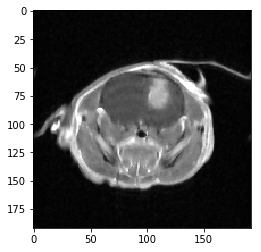

In [4]:
img2 = cv2.imread('E14_P1-1.tif')
#img2 = plt.imread('E14_P1-1.tif')
plt.imshow(img2, cmap ='gray')
img2.shape

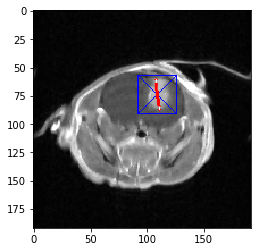

In [5]:
# showing the image to verify the selected foreground and background seeds
pts, final_image = get_points(img2) 
cv2.destroyWindow('Image')
points, seeds, box_image = VOIandSeeds(pts, final_image, thk = 3, crop = 0.15, showImg = True)
#cv2.destroyWindow('Image')

In [6]:
img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3.shape

(192, 192)

##### It is time to move to the Tumor-cut algorithm
### Step 3
To obtain the tumor strength maps for foreground and background at each voxel, run the CA algorithm on the VOI as follows:

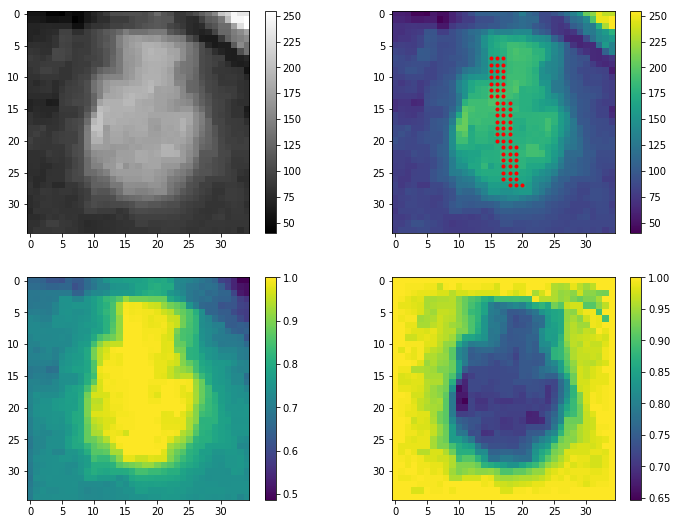

In [7]:
from tumor_cut import *

fg, bg = seeds
crop_img = tumorCut(img3, fg, bg)

#crop_img = img2[bg.min(axis=0)[1]:bg.max(axis=0)[1]+1, bg.min(axis=0)[0]:bg.max(axis=0)[0]+1]
#shiftFg_seeds = fg - bg.min(axis=0)
#plt.imshow(crop_img)
#plt.plot(shiftFg_seeds[:,0], shiftFg_seeds[:,1],'r.', linewidth = 1.0)

#plt.imshow(crop_img.selectVOI('bg'))
#plt.show()
#crop_fg=crop_img.selectVOI('fg')
#crop_bg=crop_img.selectVOI('bg')
Img_cropped = crop_img.cropImage()

fig = plt.figure(figsize=(12, 9)) 
plt.subplot(2,2,1)
plt.imshow(Img_cropped[0], cmap='gray')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(Img_cropped[0])
plt.plot(Img_cropped[1][:,0], Img_cropped[1][:,1], 'r.')
plt.colorbar()

__, bg_x = crop_img.Grow_Cut('bg', beta = 1)
__, fg_x = crop_img.Grow_Cut('fg', beta = 0.4)
plt.subplot(2,2,3)
plt.imshow(fg_x)
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(bg_x)
plt.colorbar()

### Step 4
Two strength maps are combined to obtain the tumor probability map P<sub>T</sub>. <br>
The image below shows the probability map and the associated contour level equivalent to the interface (P<sub>T</sub> = 0.5).

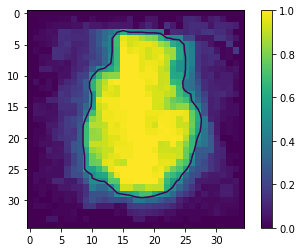

In [8]:
plt.imshow(crop_img.ProbMap())
plt.colorbar()
#plt.figure(figsize=(5, 4)) 
#plt.gca().invert_yaxis()
plt.contour(crop_img.ProbMap(), levels = [0.5])
#plt.colorbar()

### Step 5
The signed distance function is initialized by setting a interface of zero-level at P<sub>T</sub> = 0.5. And the map P<sub>T</sub> is used based on <br>
<b> ds/dt = (u - v)(u + v -2P<sub>T</sub>)N </b><br>
to evolve the surface which converges to the final segmentation map, where u, v are the means inside and outside the surface (interface), and N is the unit normal vector to surface s. 

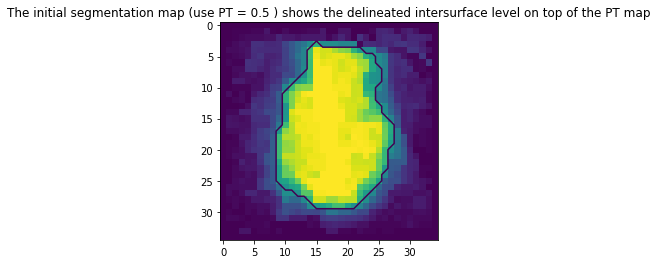

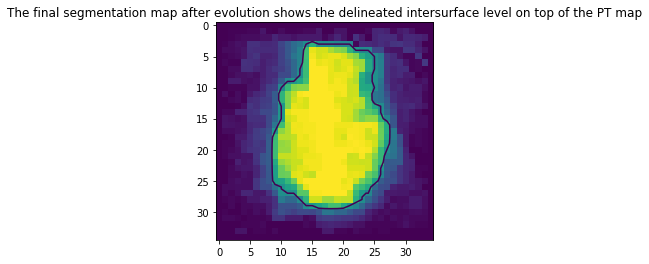

In [9]:
prob_map = crop_img.ProbMap()
from signed_distance_function import *
grad_dist = sdf(prob_map, 0.5)
plt.figure(figsize=(5, 4)) 
plt.imshow(prob_map)
#plt.gca().invert_yaxis()
plt.contour(grad_dist, levels=[0])
#plt.imshow(grad_dist, cmap = 'Greys')
#plt.colorbar()
plt.title('The initial segmentation map (use PT = 0.5 ) shows the delineated intersurface level on top of the PT map')
plt.show()
diff, S = crop_img.Level_Set_Evolution(dt = 0.03)
plt.figure(figsize=(5, 4)) 
#plt.gca().invert_yaxis()
plt.imshow(prob_map)
plt.contour(S, levels=[0])
plt.title('The final segmentation map after evolution shows the delineated intersurface level on top of the PT map')
#plt.imshow(S, cmap = 'Greys')
#plt.colorbar()

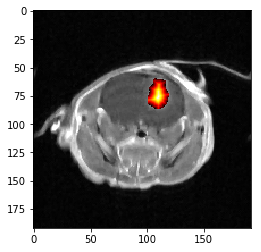

In [10]:
tmp_img = crop_img.SegMap_on_Img()
masked_img = np.ma.masked_where(tmp_img <= 0., tmp_img)

# Overlay the two images
fig, ax = plt.subplots()
ax.imshow(img2, cmap='gray')
plt.imshow(masked_img, cmap = 'hot')
plt.show()

